In [144]:
MEAS_COLUMNS = [
    "TI-19",
#      "FI-16",
#     "TI-33",
#     "FI-2",
#     "FI-151",
#     "TI-8",
#     "FI-241",
#  "valve-position-12",  # dry-bed
#     "FI-38",  # strippera
#     "PI-28",  # stripper
    
#     "TI-28",  # stripper
#      "FI-20",
#     "FI-30",
    "TI-3",
    "FI-19",
#     "FI-211",
    "FI-11",
#     "TI-30",
#     "PI-30",
    "TI-1213",
#     "TI-4",
    "FI-23",
    "FI-20",
    "FI-20/FI-23",
#    "TI-22",
    "delta_t",
    "TI-35",
    "delta_t_2"
]

In [145]:
import pandas as pd 
from darts import TimeSeries

In [166]:
from pyprocessta.model.tcn import transform_data, run_model, parallelized_inference
from pyprocessta.model.scaler import Scaler
from pyprocessta.preprocess.resample import resample_regular
import joblib

import matplotlib.pyplot as plt
plt.style.reload_library()
plt.style.use('science')
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'

In [147]:
df = pd.read_pickle('20210508_df_cleaned.pkl')
#df = resample_regular(df, '5min')

In [148]:
#df.to_pickle('df_dropped_5min_resampled.pkl')

In [149]:
TARGETS_clean = ['2-Amino-2-methylpropanol C4H11NO', 'Piperazine C4H10N2']

In [168]:
y = TimeSeries.from_dataframe(df, value_cols=TARGETS_clean)
x = TimeSeries.from_dataframe(df, value_cols=MEAS_COLUMNS)

In [169]:
transformer = Scaler()
x = transformer.fit_transform(x)

y_transformer = Scaler()
y = y_transformer.fit_transform(y)

In [170]:
model = run_model((x,y))

[2021-05-17 09:24:52,874] INFO | darts.models.torch_forecasting_model | Train dataset contains 5401 samples.
[2021-05-17 09:24:52,874] INFO | darts.models.torch_forecasting_model | Train dataset contains 5401 samples.


In [171]:
backtest = model.historical_forecasts(y,
                          covariates=x,
                          start=0.01,
                          forecast_horizon=1,
                          stride=2,
                          retrain=False,
                          verbose=False)

In [172]:
import matplotlib.pyplot as plt

In [174]:
results = parallelized_inference(model, x, y, repeats=100, start=0.1)

In [175]:
import numpy as np 

In [176]:
def summarize_results(results): 
    values = []
    
    for df in results: 
        values.append(df.pd_dataframe().values)
    
    df = df.pd_dataframe()
    columns = df.columns
    
    return pd.DataFrame(np.mean(values, axis=0), columns=columns, index=df.index), pd.DataFrame(np.std(values, axis=0), columns=columns,  index=df.index)

In [177]:
means, stds = summarize_results(results)

In [193]:
x_axis = means['1'].index - y['1'].index[0]
x_axis = [val.total_seconds() / (60 * 60 * 24) for val in x_axis]

x_conncected = y['1'].index - y['1'].index[0]
x_conncected = [val.total_seconds() / (60 * 60 * 24) for val in x_conncected]

In [191]:
len(results[0])

2434

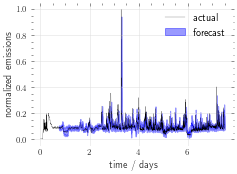

In [194]:
plt.plot(x_axis, means['1'], c='b',  alpha=.9, lw=.2)
plt.fill_between(x_axis, means['1']-2*stds['1'], means['1']+2*stds['1'], alpha=.4, color='b', label='forecast',)
plt.plot(x_conncected, y['1'], c='k', label='actual', lw=.2,)

plt.legend()
#plt.xticks([])

plt.xlabel('time / days')
plt.ylabel('normalized emissions')
plt.tight_layout()
plt.savefig('piperazine_forecast_all.pdf', bbox_inches='tight')

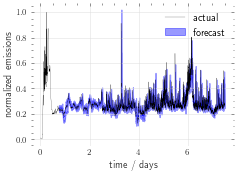

In [195]:
plt.plot(x_axis, means['0'], c='b',  alpha=.9, lw=.2)
plt.fill_between(x_axis, means['0']-2*stds['0'], means['0']+2*stds['0'], alpha=.4, color='b', label='forecast',)
plt.plot(x_conncected, y['0'], c='k', label='actual', lw=.2,)

plt.legend()
#plt.xticks([])

plt.xlabel('time / days')
plt.ylabel('normalized emissions')
plt.tight_layout()
plt.savefig('amp_forecast_all.pdf', bbox_inches='tight')

In [157]:
joblib.dump(model, '2amp_pip_model_reduced_feature_set')
joblib.dump(transformer, 'x_scaler_reduced_feature_set')
joblib.dump(y_transformer, 'y_transformer__reduced_feature_set')

['y_transformer__reduced_feature_set']

## Now, also build a model for CO2 and NH3

In [196]:
NEW_TARGETS = ["Carbon dioxide CO2", "Ammonia NH3"]

In [197]:
y = TimeSeries.from_dataframe(df, value_cols=NEW_TARGETS)
x = TimeSeries.from_dataframe(df, value_cols=MEAS_COLUMNS)

In [198]:
transformer = Scaler()
x = transformer.fit_transform(x)

y_transformer = Scaler()
y = y_transformer.fit_transform(y)

In [199]:
model_co2 = run_model((x,y))

[2021-05-17 16:24:24,597] INFO | darts.models.torch_forecasting_model | Train dataset contains 5401 samples.
[2021-05-17 16:24:24,597] INFO | darts.models.torch_forecasting_model | Train dataset contains 5401 samples.


In [200]:
backtest_c02 = model_co2.historical_forecasts(y,
                          covariates=x,
                          start=0.01,
                          forecast_horizon=1,
                          stride=2,
                          retrain=False,
                          verbose=False)

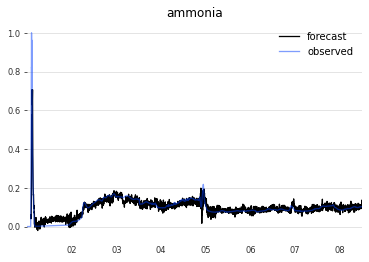

In [163]:
backtest_c02['1'].plot(label='forecast')
y['1'].plot(alpha=.5, label='observed')
plt.xticks([], [])
plt.legend()
plt.title('ammonia')
plt.savefig('ammonia_forecast.pdf', bbox_inches='tight')

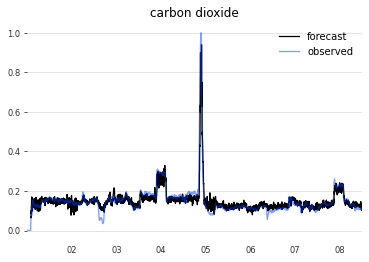

In [164]:
backtest_c02['0'].plot(label='forecast')
y['0'].plot(alpha=.5, label='observed')
plt.xticks([], [])
plt.legend()
plt.title('carbon dioxide')
plt.savefig('co2_forecast.pdf', bbox_inches='tight')

In [165]:
joblib.dump(model_co2, 'co2_ammonia_model_reduced_feature_set')
joblib.dump(y_transformer, 'y_transformer_co2_ammonia_reduced_feature_set')

['y_transformer_co2_ammonia_reduced_feature_set']

In [ ]:
results_co2 = parallelized_inference(model_co2, x, y, repeats=100, start=0.1)